## Marriott: RFM Based LTV Calculation

Reference:  <a href="https://lifetimes.readthedocs.io/en/latest/Quickstart.html?highlight=BetaGeoFitter#basic-frequency-recency-analysis-using-the-bg-nbd-model">Lifetimes</a>

## Import libraries and define auxiliary functions

In [1]:
# file
#!pip install pyarrow 
import pyarrow as pa
import pyarrow.parquet as pq
# basic
import math
import random
import pandas as pd
import numpy as np
import scipy
# data transform
from sklearn import *
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
# time series analysis
from datetime import datetime, date
# RFM & CLV
import lifetimes
from lifetimes import BetaGeoFitter # BG/NBD
from lifetimes import GammaGammaFitter # Gamma-Gamma Model
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.utils import calibration_and_holdout_data # train and test
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
# segmentation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# plot
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import squarify
# ignore warnings
import warnings; warnings.filterwarnings('ignore')

In [2]:
pd.__version__

'1.4.2'

### Pre-defined Functions

In [3]:
# print stats
def print_stats(df):
    # calculate relavent stats
    n_a = df['Customer_Id'].nunique()
    n_trans = df.Num_Transactions.sum()
    avg_trans = round(n_trans/n_a)
    n_p = df['Product_Category'].nunique()
    n = df[df['Customer_Id'].isnull()].shape[0]
    start = df['Latest_Transaction_Date'].min()
    end = df['Latest_Transaction_Date'].max()
    # an overview
    s = '------------------------------------------------------------------------------------'
    print(f'\nTransactions timeframe from {start} to {end}'); print(s)
    print(f'Total {n_trans} transactions were made in this timeframe'); print(s)
    print(f'Total {n_a} customers, and average number of transactions is {avg_trans}'); print(s)
    print(f'{n} Transactions don\'t have a agent number'); print(s)

In [4]:
def find_boundaries(df, variable,q1=0.05,q2=0.95):
# the boundaries are the quantiles
    lower_boundary = round(df[variable].quantile(q1),4) # lower quantile
    upper_boundary = round(df[variable].quantile(q2),4) # upper quantile
    return upper_boundary, lower_boundary

def capping_outliers(df,variable):
    upper_boundary,lower_boundary =  find_boundaries(df,variable)
    df[variable] = np.where(df[variable] > upper_boundary, upper_boundary,
    np.where(df[variable] < lower_boundary, lower_boundary, df[variable]))

## Read & Inspect Data

In [3]:
df = pd.read_parquet('data_correct.parquet', engine='pyarrow')
df.head()

,Customer_Id,Calendar_Year,Calendar_Month,Product_Category,Latest_Transaction_Date,Num_Transactions,Total_Spend,Marriott_Revenue,Week_Number,Day_of_Week,Day,Service_Category
0,3739303434323531,2019,11,Hotel Other,2019-11-05,2,40.950001,1.44,45,Tuesday,5,Hotel
1,3830323235373536,2014,11,Hotel Other,2014-11-28,2,0.000000,0.00,48,Friday,28,Hotel
2,3736393638313136,2019,6,Hotel F&B,2019-06-18,2,152.729996,6.66,25,Tuesday,18,Hotel
3,3733393339353733,2010,2,Hotel Other,2010-02-08,2,103.500000,4.26,6,Monday,8,Hotel
4,3734313235383637,2007,9,Hotel Other,2007-09-29,5,261.649994,10.33,39,Saturday,29,Hotel


In [4]:
r, c = df.shape
print(f"This dataset has {r} rows and {c} columns")

This dataset has 55656798 rows and 12 columns


In [5]:
# exclude non-positive values
df = df[(df['Marriott_Revenue']>0)]

In [6]:
df_hotel = df[df['Service_Category'] == "Hotel"]
df_card = df[df['Service_Category'] == "Card"]
df_rental = df[df['Service_Category'] == "Home Rentals"]

In [142]:
#df_hotel
print_stats(df_hotel)


Transactions timeframe from 2001-01-01 00:00:00 to 2022-09-28 00:00:00
------------------------------------------------------------------------------------
Total 142397286 transactions were made in this timeframe
------------------------------------------------------------------------------------
Total 992581 customers, and average number of transactions is 143
------------------------------------------------------------------------------------
0 Transactions don't have a agent number
------------------------------------------------------------------------------------


In [143]:
#df_card
print_stats(df_card)


Transactions timeframe from 2016-09-01 00:00:00 to 2022-08-31 00:00:00
------------------------------------------------------------------------------------
Total 147495416 transactions were made in this timeframe
------------------------------------------------------------------------------------
Total 170124 customers, and average number of transactions is 867
------------------------------------------------------------------------------------
0 Transactions don't have a agent number
------------------------------------------------------------------------------------


In [144]:
#df_rental
print_stats(df_rental)


Transactions timeframe from 2019-05-28 00:00:00 to 2022-09-27 00:00:00
------------------------------------------------------------------------------------
Total 7630 transactions were made in this timeframe
------------------------------------------------------------------------------------
Total 2843 customers, and average number of transactions is 3
------------------------------------------------------------------------------------
0 Transactions don't have a agent number
------------------------------------------------------------------------------------


## RFM calculation

### All Product Category

In [7]:
# By default the first transaction is not included while calculating frequency and monetary_value.
clv_all = lifetimes.utils.summary_data_from_transaction_data(df, 'Customer_Id', 
                                                             'Latest_Transaction_Date', 
                                                             'Marriott_Revenue', 
                                                             observation_period_end='2022-10-01',
                                                             # let's include the first purchase
                                                             include_first_transaction = 'True')
# we want only customers shopped more than 2 times
clv_all = clv_all[clv_all['frequency'] > 1]
#only monetary_value >0?
clv_all = clv_all[clv_all['monetary_value'] > 0]
clv_all.sort_values('monetary_value', ascending=False).head()

,frequency,recency,T,monetary_value
Customer_Id,,,,
323938343639353235,27.0,1339.0,1346.0,34301.363281
313532383939363435,84.0,2529.0,2538.0,3624.875000
33313632303035,10.0,664.0,2435.0,3428.113037
313731303233303830,85.0,2203.0,2206.0,2909.398438
323635323833383032,5.0,1317.0,1463.0,2796.820068


### Hotel Calculation

In [10]:
# By default the first transaction is not included while calculating frequency and monetary_value.
clv_hotel = lifetimes.utils.summary_data_from_transaction_data(df_hotel, 'Customer_Id', 
                                                             'Latest_Transaction_Date', 
                                                             'Marriott_Revenue', 
                                                             observation_period_end='2022-10-01',
                                                             # let's include the first purchase
                                                             include_first_transaction = 'True')
# we want only customers shopped more than 2 times
clv_hotel = clv_hotel[clv_hotel['frequency'] > 1]
#only monetary_value >0?
clv_hotel = clv_hotel[clv_hotel['monetary_value'] > 0]
clv_hotel.sort_values('monetary_value', ascending=False).head()

,frequency,recency,T,monetary_value
Customer_Id,,,,
33313632303035,10.0,664.0,2435.0,3428.113037
323333363334353136,113.0,4866.0,5624.0,2782.759766
323234323330323036,9.0,476.0,2284.0,2781.704346
323230303437373635,29.0,2303.0,2345.0,2355.986572
3234323735303631,26.0,483.0,2046.0,2353.186523


### Card Calculation

In [11]:
# By default the first transaction is not included while calculating frequency and monetary_value.
clv_card = lifetimes.utils.summary_data_from_transaction_data(df_card, 'Customer_Id', 
                                                             'Latest_Transaction_Date', 
                                                             'Marriott_Revenue', 
                                                             observation_period_end='2022-10-01',
                                                             # let's include the first purchase
                                                             include_first_transaction = 'True')

# we want only customers shopped more than 2 times
clv_card = clv_card[clv_card['frequency'] > 1]
#only monetary_value >0?
clv_card = clv_card[clv_card['monetary_value'] > 0]
clv_card.sort_values('monetary_value', ascending=False).head()

,frequency,recency,T,monetary_value
Customer_Id,,,,
323636343339363933,71.0,2169.0,2217.0,5604.905762
313731303233303830,55.0,1744.0,2206.0,4376.886230
3436393137363538,71.0,2178.0,2211.0,3707.868896
323230303635353939,69.0,2159.0,2199.0,3062.119385
323236323232323933,24.0,1668.0,1721.0,2414.605957


### Home Rental Calculation

In [12]:
# By default the first transaction is not included while calculating frequency and monetary_value.
clv_rental = lifetimes.utils.summary_data_from_transaction_data(df_rental, 'Customer_Id', 
                                                             'Latest_Transaction_Date', 
                                                             'Marriott_Revenue', 
                                                             observation_period_end='2022-10-01',
                                                             # let's include the first purchase
                                                             include_first_transaction = 'True')

# we want only customers shopped more than 2 times
clv_rental = clv_rental[clv_rental['frequency'] > 1]
#only monetary_value >0?
clv_rental = clv_rental[clv_rental['monetary_value'] > 0]
clv_rental.sort_values('monetary_value', ascending=False).head()

,frequency,recency,T,monetary_value
Customer_Id,,,,
323432373139333738,2.0,130.0,231.0,11149.925781
313736313239383336,3.0,369.0,423.0,9161.653320
3734343038,2.0,344.0,377.0,8634.315430
313337363530313637,2.0,187.0,313.0,6843.259766
3339333330363239,2.0,59.0,277.0,5590.594727


## All Category CLV Calculation

In [8]:
# we want only customers shopped more than 2 times
clv_calculation = clv_all[clv_all['frequency'] > 1]

clv_calculation.sort_values('monetary_value', ascending=False).head()

,frequency,recency,T,monetary_value
Customer_Id,,,,
323938343639353235,27.0,1339.0,1346.0,34301.363281
313532383939363435,84.0,2529.0,2538.0,3624.875000
33313632303035,10.0,664.0,2435.0,3428.113037
313731303233303830,85.0,2203.0,2206.0,2909.398438
323635323833383032,5.0,1317.0,1463.0,2796.820068


### Basic Frequency/Recency analysis using the BG/NBD model

In [10]:
bgf = BetaGeoFitter(penalizer_coef=0.05) # penalize overfitting
bgf.fit(clv_calculation['frequency'], clv_calculation['recency'], clv_calculation['T'])

<lifetimes.BetaGeoFitter: fitted with 801326 subjects, a: 0.09, alpha: 92.01, b: 0.97, r: 1.17>

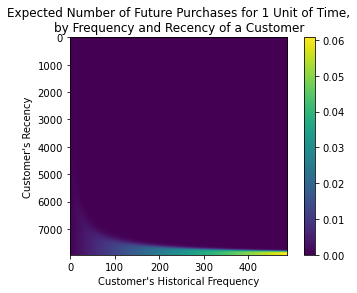

In [152]:
plot_frequency_recency_matrix(bgf);

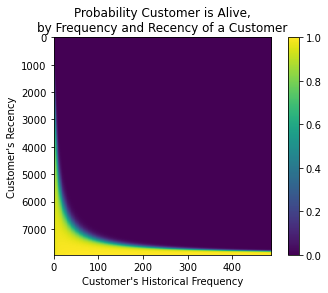

In [153]:
plot_probability_alive_matrix(bgf);

### Ranking customers from best to worst

In [11]:
t = 180 # calculate every half year
clv_calculation['predicted_purchases_180d'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, clv_calculation['frequency'], clv_calculation['recency'], clv_calculation['T'])
clv_calculation.sort_values(by='predicted_purchases_180d').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases_180d
Customer_Id,,,,,
323036373535373335,183.0,2123.0,2134.0,44.781040,14.823837
323239393535333834,232.0,2645.0,2656.0,56.776421,15.216009
3738373637,135.0,1454.0,1463.0,264.557129,15.663568
3737393837313430,203.0,2177.0,2214.0,56.875519,15.701746
313432313835393533,145.0,1570.0,1574.0,64.254829,15.707458


In [156]:
# gamma gamma model cannot be used when frequency is strongly related to monetary value
clv_calculation[['frequency','monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.044264
monetary_value,0.044264,1.000000


### Predict CLV for next 180 days using GammaGamma model (start at 2022/10/1)

In [12]:
# In typical applications, penalizers on the order of 0.001 to 0.1 are effective
ggf = GammaGammaFitter(penalizer_coef=0.1) # l2 penalty
ggf.fit(clv_calculation["frequency"], clv_calculation["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 801326 subjects, p: 1.21, q: 0.37, v: 1.19>

In [13]:
clv_calculation['clv_180d']=ggf.customer_lifetime_value(bgf,
                                   clv_calculation["frequency"],
                                   clv_calculation["recency"],
                                   clv_calculation["T"],
                                   clv_calculation["monetary_value"],
                                   # size of pattern
                                   # weights=1,
                                   # the lifetime expected for the user in months
                                   time=6,
                                   # what unit of time your T is measure in
                                   freq='D',
                                   # the monthly adjusted discount rate.
                                   discount_rate=0.1)

In [14]:
p1 = round(ggf.conditional_expected_average_profit(clv_calculation['frequency'], clv_calculation['monetary_value']).mean(),4)
p2 = round(clv_calculation[clv_calculation['frequency']>0]['monetary_value'].mean(),4)
print("Expected conditional average profit: %s, Average profit: %s" % (p1,p2))

Expected conditional average profit: 28.081, Average profit: 26.7846


In [15]:
clv_calculation.sort_values('clv_180d').tail()

,frequency,recency,T,monetary_value,predicted_purchases_180d,clv_180d
Customer_Id,,,,,,
3436393137363538,163.0,2451.0,2464.0,1683.428589,11.512404,18780.135880
313731303233303830,85.0,2203.0,2206.0,2909.398438,6.719314,18999.551793
313532383939363435,84.0,2529.0,2538.0,3624.875000,5.803967,20448.566508
323636343339363933,160.0,2366.0,2387.0,2594.512695,11.641469,29270.313672
323938343639353235,27.0,1339.0,1346.0,34301.363281,3.494192,118046.409682


In [16]:
clv_result = clv_calculation[['predicted_purchases_180d', 'clv_180d']]
clv_result.head()

,predicted_purchases_180d,clv_180d
Customer_Id,,
3137,0.023910,0.877576
3139,0.000043,0.001198
3639,1.845501,46.873497
3837,0.291385,2.664359
3932,3.531073,66.391201


<AxesSubplot:xlabel='predicted_purchases_180d', ylabel='Density'>

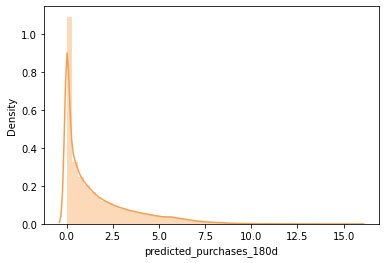

In [17]:
sns.distplot(clv_result['predicted_purchases_180d'],color='#f5a051')

<AxesSubplot:xlabel='clv_180d', ylabel='Density'>

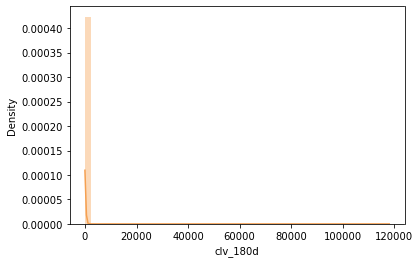

In [18]:
sns.distplot(clv_result['clv_180d'],color='#f5a051')

### Model Assessment

#### With transactional data, we can partition the dataset into a calibration period dataset and a holdout dataset

In [161]:
# split like train and test
summary_cal_holdout = calibration_and_holdout_data(df, 'Customer_Id', 
                                                       'Latest_Transaction_Date',
                                                        calibration_period_end='2022-2-28',
                                                        observation_period_end='2022-8-31' )
print(summary_cal_holdout.head())

             frequency_cal  recency_cal   T_cal  frequency_holdout  \
Customer_Id                                                          
3137                  48.0       6442.0  7695.0                0.0   
3139                 121.0       6818.0  7711.0                0.0   
3639                  43.0       4239.0  4261.0                2.0   
3837                  41.0       6113.0  7016.0                0.0   
3932                 142.0       7353.0  7385.0                6.0   

             duration_holdout  
Customer_Id                    
3137                    184.0  
3139                    184.0  
3639                    184.0  
3837                    184.0  
3932                    184.0  


<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

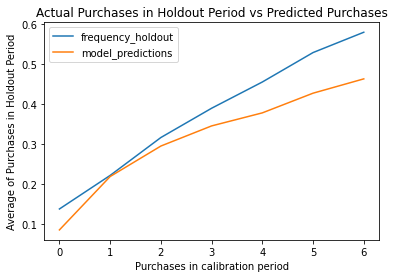

In [162]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

## RFM Segments

In [13]:
def segment(row):
    R = row['R_score']
    FM = row['FM_score']
    if 4<=R<=5 and 4<=FM<=5:
        seg = 'Champions'
    elif 2<=R<=5 and 3<=FM<=5:
        seg = 'Loyal Customers'
    elif 3<=R<=5 and 1<=FM<=3:
        seg = 'Potential Loyalist'   
    elif 4<=R<=5 and 0<=FM<=1:
        seg = 'Recent Customers' 
    elif 3<=R<=4 and 0<=FM<=1:
        seg = 'Promising' 
    elif 2<=R<=3 and 2<=FM<=3:
        seg = 'Need Attention'
    elif 2<=R<=3 and 0<=FM<=2:
        seg = 'About To Sleep'
    elif 0<=R<=2 and 2<=FM<=5:
        seg = 'At Risk'
    elif 0<=R<=1 and 4<=FM<=5:
        seg = 'Can’t Lose Them'
    elif 1<=R<=2 and 1<=FM<=2:
        seg = 'Hibernating'
    elif 0<=R<=2 and 0<=FM<=2:
        seg = 'Lost'
    else:
        seg = '?'
    return seg

### All Product Category

In [164]:
# divide customers into 5 groups by R, F, M
clv_all['R_score'] = pd.qcut(clv_all['recency'], 5, labels=[5, 4, 3, 2, 1])
clv_all['F_score'] = pd.qcut(clv_all['frequency'], 5, labels=[1, 2, 3, 4, 5])
clv_all['M_score'] = pd.qcut(clv_all['monetary_value'], 5, labels=[1, 2, 3, 4, 5])
clv_all['FM_score'] = (clv_all['F_score'].astype(float)+clv_all['M_score'].astype(float))/2

#segment
clv_all['RFM_segments'] = clv_all.apply(segment, axis=1)
clv_all.head()

,frequency,recency,T,monetary_value,R_score,F_score,M_score,FM_score,RFM_segments
Customer_Id,,,,,,,,,
3137,49.0,6442.0,7910.0,37.571224,1,4,5,4.5,At Risk
3139,122.0,6818.0,7926.0,28.666147,1,5,4,4.5,At Risk
3639,46.0,4375.0,4476.0,25.971956,2,4,4,4.0,Loyal Customers
3837,42.0,6113.0,7231.0,9.320952,1,4,1,2.5,At Risk
3932,150.0,7583.0,7600.0,19.389999,1,5,3,4.0,At Risk


In [165]:
clv_all.RFM_segments.value_counts()

Loyal Customers       300684
Potential Loyalist    264413
At Risk               158291
Need Attention         37905
Champions              29899
About To Sleep          8161
Hibernating             1973
Name: RFM_segments, dtype: int64

In [166]:
clv_all['Total'] = clv_all.groupby('RFM_segments').RFM_segments.transform('count')
clv_all.sort_values('Total', ascending=False, inplace=True)
clv_all.head()

,frequency,recency,T,monetary_value,R_score,F_score,M_score,FM_score,RFM_segments,Total
Customer_Id,,,,,,,,,,
313530313239313031,21.0,2350.0,2411.0,37.091904,3,3,5,4.0,Loyal Customers,300684
3736313231333138,12.0,1959.0,5927.0,81.731667,4,2,5,3.5,Loyal Customers,300684
3736313231363337,65.0,5188.0,7885.0,26.014769,2,4,4,4.0,Loyal Customers,300684
313334363438353430,16.0,4222.0,6742.0,39.409374,2,2,5,3.5,Loyal Customers,300684
3736313231363238,7.0,3654.0,6829.0,54.841431,3,1,5,3.0,Loyal Customers,300684


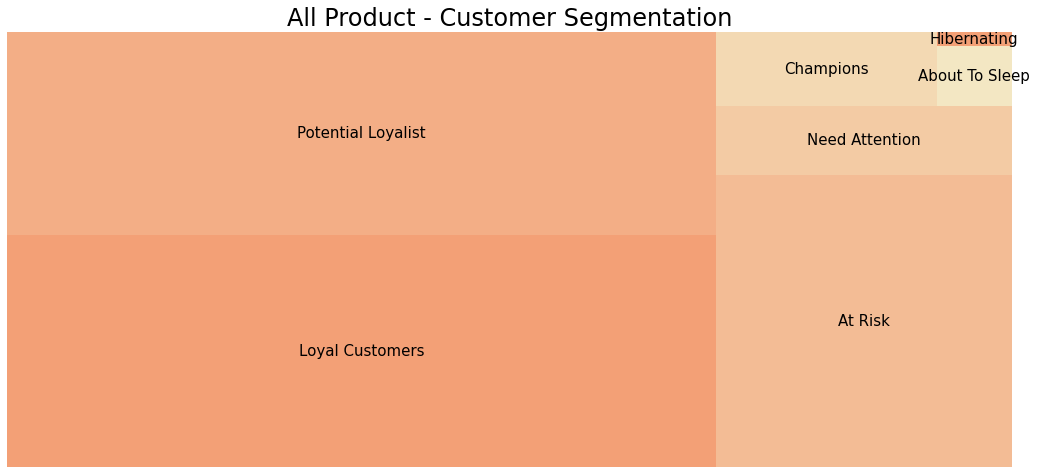

In [167]:
# visualize
RFM_segments = clv_all.RFM_segments.value_counts().reset_index()
RFM_segments.columns = ['labels', 'count']
names = RFM_segments['labels'].apply(str.title)
# plot
plt.figure(figsize=(18,8))
squarify.plot(sizes=RFM_segments['count'], label=names, 
                  color=sns.color_palette("blend:#ee783d,#EDA"), 
                  alpha=.7, text_kwargs={'fontsize':15})
plt.axis('off')
plt.title("All Product - Customer Segmentation", fontsize=24)
plt.savefig('All Product Segmentation.png',transparent=True) 
plt.show()

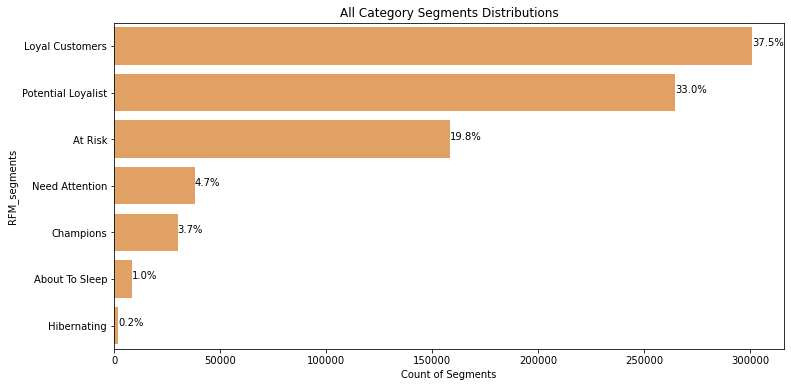

In [168]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(y="RFM_segments", data=clv_all, color='#f5a051')
plt.title('All Category Segments Distributions')
plt.xlabel('Count of Segments')

total = len(clv_all)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

In [175]:
clv_all = pd.merge(clv_all, clv_result, on='Customer_Id',  how='left')
clv_all.head()

,frequency,recency,T,monetary_value,R_score,F_score,M_score,FM_score,RFM_segments,Total,predicted_purchases_180d,clv_180d
Customer_Id,,,,,,,,,,,,
313530313239313031,21.0,2350.0,2411.0,37.091904,3,3,5,4.0,Loyal Customers,300684,1.577945e+00,5.805770e+01
3736313231333138,12.0,1959.0,5927.0,81.731667,4,2,5,3.5,Loyal Customers,300684,3.774612e-05,3.118498e-03
3736313231363337,65.0,5188.0,7885.0,26.014769,2,4,4,4.0,Loyal Customers,300684,1.549424e-09,3.927548e-08
313334363438353430,16.0,4222.0,6742.0,39.409374,2,2,5,3.5,Loyal Customers,300684,2.889107e-02,1.138818e+00
3736313231363238,7.0,3654.0,6829.0,54.841431,3,1,5,3.0,Loyal Customers,300684,7.379792e-02,4.235612e+00


In [231]:
clv_all_result = clv_all.groupby('RFM_segments', as_index=False)['predicted_purchases_180d','clv_180d'].agg(['mean']).reset_index()
clv_all_result.columns = clv_all_result.columns.droplevel(-1)
clv_all_result

,RFM_segments,predicted_purchases_180d,clv_180d
0,About To Sleep,0.246860,2.781346
1,At Risk,2.194142,61.836159
2,Champions,3.813455,191.683121
3,Hibernating,0.279730,3.070283
4,Loyal Customers,1.934448,63.446649
5,Need Attention,0.625704,7.847781
6,Potential Loyalist,0.822956,10.733958


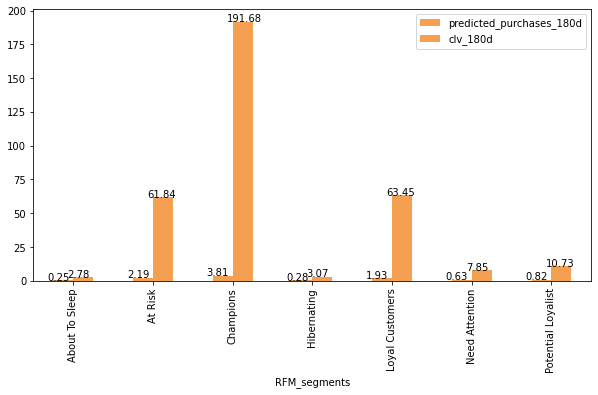

In [244]:
fig, ax = plt.subplots(figsize=(10,5))
clv_all_result.plot.bar(x = 'RFM_segments', y = ['predicted_purchases_180d', 'clv_180d'], ax = ax, color='#f5a051')
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2-0.2, p.get_height()))

### Hotel

In [14]:
# divide customers into 5 groups by R, F, M
clv_hotel['R_score'] = pd.qcut(clv_hotel['recency'], 5, labels=[5, 4, 3, 2, 1])
clv_hotel['F_score'] = pd.qcut(clv_hotel['frequency'], 5, labels=[1, 2, 3, 4, 5])
clv_hotel['M_score'] = pd.qcut(clv_hotel['monetary_value'], 5, labels=[1, 2, 3, 4, 5])
clv_hotel['FM_score'] = (clv_hotel['F_score'].astype(float)+clv_hotel['M_score'].astype(float))/2

#segment
clv_hotel['RFM_segments'] = clv_hotel.apply(segment, axis=1)
clv_hotel.head()

,frequency,recency,T,monetary_value,R_score,F_score,M_score,FM_score,RFM_segments
Customer_Id,,,,,,,,,
3137,49.0,6442.0,7910.0,37.571224,1,4,5,4.5,At Risk
3139,122.0,6818.0,7926.0,28.666147,1,5,4,4.5,At Risk
3639,46.0,4375.0,4476.0,25.971956,2,4,4,4.0,Loyal Customers
3837,42.0,6113.0,7231.0,9.320952,1,4,1,2.5,At Risk
3932,150.0,7583.0,7600.0,19.389999,1,5,3,4.0,At Risk


In [15]:
clv_hotel.RFM_segments.value_counts()

Loyal Customers       326190
Potential Loyalist    296332
At Risk               171780
Need Attention         37096
Champions              26846
About To Sleep          6930
Hibernating             1566
Name: RFM_segments, dtype: int64

In [16]:
clv_hotel['Total'] = clv_hotel.groupby('RFM_segments').RFM_segments.transform('count')
clv_hotel.sort_values('Total', ascending=False, inplace=True)
clv_hotel.head()

,frequency,recency,T,monetary_value,R_score,F_score,M_score,FM_score,RFM_segments,Total
Customer_Id,,,,,,,,,,
3437363437393933,49.0,2375.0,2441.0,93.033875,3,4,5,4.5,Loyal Customers,326190
3735383637393931,96.0,5278.0,5289.0,15.829792,2,5,2,3.5,Loyal Customers,326190
3735383637393134,72.0,4181.0,4281.0,8.017083,2,5,1,3.0,Loyal Customers,326190
3735383637383532,84.0,4165.0,4169.0,10.571786,2,5,1,3.0,Loyal Customers,326190
313239383736313035,49.0,2735.0,2745.0,13.545714,3,4,2,3.0,Loyal Customers,326190


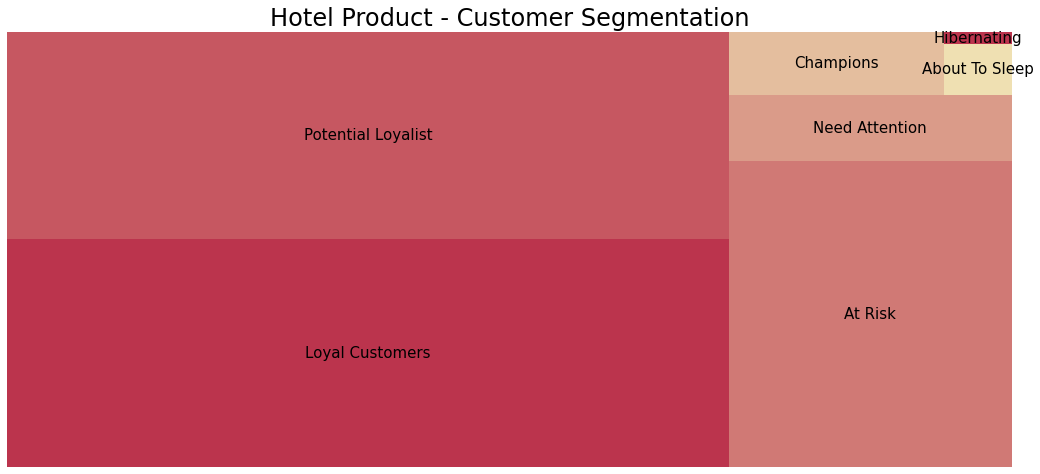

In [17]:
# visualize the top 7 on Merchant_Category
RFM_segments = clv_hotel.RFM_segments.value_counts().reset_index()
RFM_segments.columns = ['labels', 'count']
names = RFM_segments['labels'].apply(str.title)
# plot
plt.figure(figsize=(18,8))
squarify.plot(sizes=RFM_segments['count'], label=names, 
                  color=sns.color_palette("blend:#b41f3a,#EDA"), 
                  alpha=.9, text_kwargs={'fontsize':15})
plt.axis('off')
plt.title("Hotel Product - Customer Segmentation", fontsize=24)
plt.savefig('Hotel Segmentation.png',transparent=True) 
plt.show()

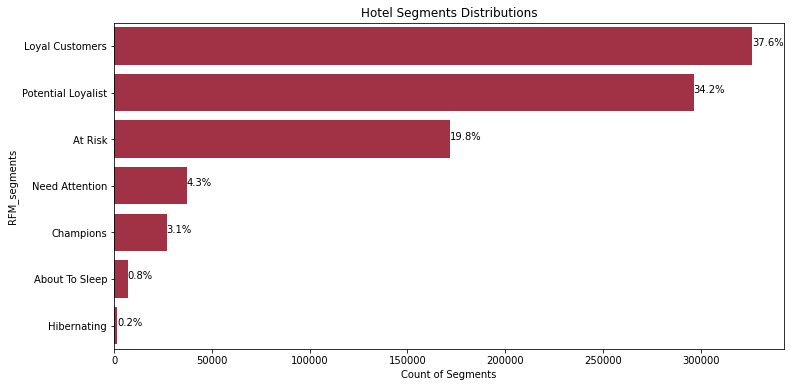

In [18]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(y="RFM_segments", data=clv_hotel, color='#b41f3a')
plt.title('Hotel Segments Distributions')
plt.xlabel('Count of Segments')

total = len(clv_hotel)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

In [259]:
clv_hotel = pd.merge(clv_hotel, clv_result, on='Customer_Id',  how='left')
clv_hotel.head()

,frequency,recency,T,monetary_value,R_score,F_score,M_score,FM_score,RFM_segments,Total,predicted_purchases_180d,clv_180d
Customer_Id,,,,,,,,,,,,
313530323135373538,74.0,3835.0,3845.0,66.340538,3,5,5,5.0,Loyal Customers,294908,3.425101,221.086487
3430313831313131,37.0,2399.0,3019.0,23.806486,3,4,3,3.5,Loyal Customers,294908,0.178465,4.167933
323632303036323238,14.0,2661.0,2688.0,51.715714,3,2,5,3.5,Loyal Customers,294908,2.069091,56.777640
31343833353735,38.0,2503.0,2545.0,13.851842,3,4,2,3.0,Loyal Customers,294908,7.328293,158.608056
31343833353833,11.0,3225.0,4463.0,31.735455,3,2,4,3.0,Loyal Customers,294908,0.349042,11.268049


In [260]:
clv_hotel_result = clv_hotel.groupby('RFM_segments', as_index=False)['predicted_purchases_180d','clv_180d'].agg(['mean']).reset_index()
clv_hotel_result.columns = clv_hotel_result.columns.droplevel(-1)
clv_hotel_result

,RFM_segments,predicted_purchases_180d,clv_180d
0,About To Sleep,0.363384,3.875189
1,At Risk,2.189300,62.162067
2,Champions,3.138661,160.478628
3,Hibernating,0.401053,4.182336
4,Loyal Customers,1.838064,62.128287
5,Need Attention,0.729953,10.021542
6,Potential Loyalist,0.933563,14.949202


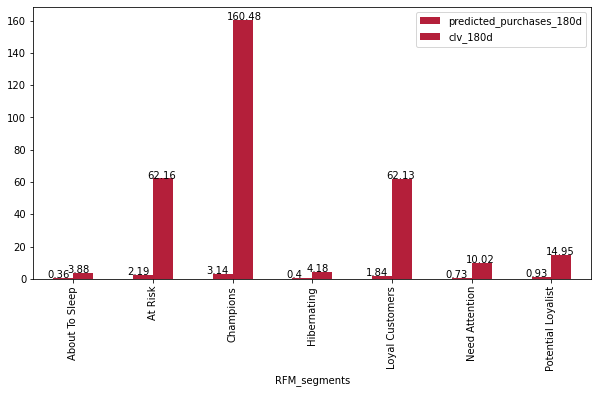

In [261]:
fig, ax = plt.subplots(figsize=(10,5))
clv_hotel_result.plot.bar(x = 'RFM_segments', y = ['predicted_purchases_180d', 'clv_180d'], ax = ax, color='#b41f3a')
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2-0.2, p.get_height()))

### Card

In [24]:
# divide customers into 5 groups by R, F, M
clv_card['R_score'] = pd.qcut(clv_card['recency'], 5, labels=[5, 4, 3, 2, 1])
clv_card['F_score'] = pd.qcut(clv_card['frequency'], 5, labels=[1, 2, 3, 4, 5])
clv_card['M_score'] = pd.qcut(clv_card['monetary_value'], 5, labels=[1, 2, 3, 4, 5])
clv_card['FM_score'] = (clv_card['F_score'].astype(float)+clv_card['M_score'].astype(float))/2

#segment
clv_card['RFM_segments'] = clv_card.apply(segment, axis=1)
clv_card.head()

,frequency,recency,T,monetary_value,R_score,F_score,M_score,FM_score,RFM_segments
Customer_Id,,,,,,,,,
313333,70.0,2157.0,2218.0,9.829572,1,5,3,4.0,At Risk
323635,44.0,1636.0,1723.0,44.718182,3,3,5,4.0,Loyal Customers
333034,55.0,1673.0,1712.0,12.980182,2,4,3,3.5,Loyal Customers
333536,41.0,1206.0,1259.0,8.923171,4,3,3,3.0,Loyal Customers
343238,46.0,1671.0,1724.0,57.303913,3,3,5,4.0,Loyal Customers


In [25]:
clv_hotel.RFM_segments.value_counts()

Loyal Customers       326190
Potential Loyalist    296332
At Risk               171780
Need Attention         37096
Champions              26846
About To Sleep          6930
Hibernating             1566
Name: RFM_segments, dtype: int64

In [26]:
clv_card['Total'] = clv_card.groupby('RFM_segments').RFM_segments.transform('count')
clv_card.sort_values('Total', ascending=False, inplace=True)
clv_card.head()

,frequency,recency,T,monetary_value,R_score,F_score,M_score,FM_score,RFM_segments,Total
Customer_Id,,,,,,,,,,
313339353639343337,29.0,1642.0,1706.0,18.819654,3,2,4,3.0,Loyal Customers,67377
3937313639353935,56.0,1673.0,1724.0,27.701963,2,4,5,4.5,Loyal Customers,67377
3937313730383837,42.0,1307.0,1342.0,23.525715,4,3,4,3.5,Loyal Customers,67377
3937313730373037,52.0,1554.0,1600.0,19.489038,3,4,4,4.0,Loyal Customers,67377
323133393432313530,56.0,1673.0,1714.0,8.764464,2,4,3,3.5,Loyal Customers,67377


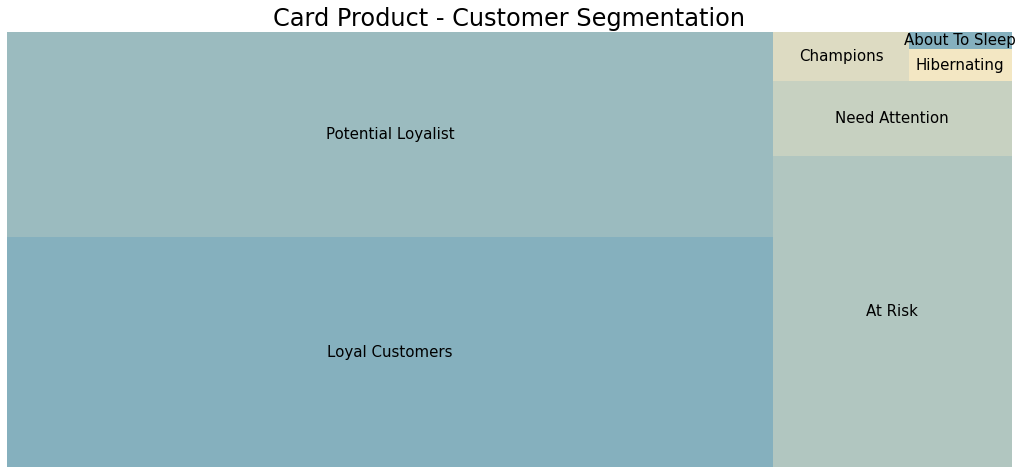

In [27]:
# visualize the top 7 on Merchant_Category
RFM_segments = clv_card.RFM_segments.value_counts().reset_index()
RFM_segments.columns = ['labels', 'count']
names = RFM_segments['labels'].apply(str.title)
# plot
plt.figure(figsize=(18,8))
squarify.plot(sizes=RFM_segments['count'], label=names, 
                  color=sns.color_palette("blend:#528fa3,#EDA"), 
                  alpha=.7, text_kwargs={'fontsize':15})
plt.axis('off')
plt.title("Card Product - Customer Segmentation", fontsize=24)
plt.savefig('Card Segmentation.png',transparent=True) 
plt.show()

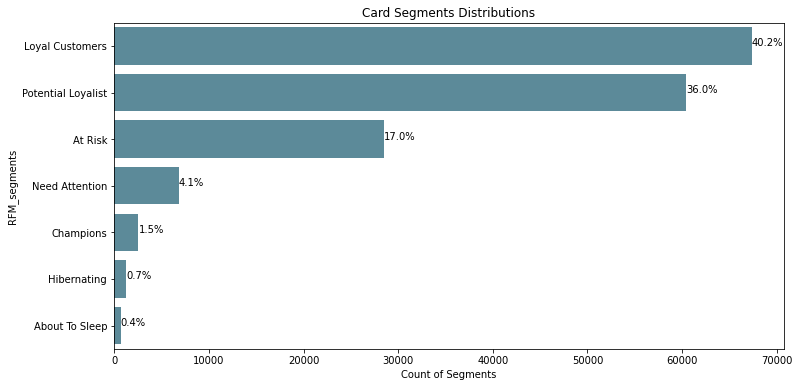

In [28]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(y="RFM_segments", data=clv_card, color='#528fa3')
plt.title('Card Segments Distributions')
plt.xlabel('Count of Segments')

total = len(clv_card)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

In [267]:
clv_card = pd.merge(clv_card, clv_result, on='Customer_Id',  how='left')
clv_card.head()

,frequency,recency,T,monetary_value,R_score,F_score,M_score,FM_score,RFM_segments,Total,predicted_purchases_180d,clv_180d
Customer_Id,,,,,,,,,,,,
3738323933373832,22.0,671.0,713.0,28.365910,5,2,5,3.5,Loyal Customers,66386,7.736892,295.130283
323136333838393231,17.0,1672.0,1716.0,39.831177,3,1,5,3.0,Loyal Customers,66386,6.030495,203.563870
323136333839353238,53.0,1673.0,1712.0,12.723396,3,4,3,3.5,Loyal Customers,66386,4.620977,92.051650
323136333839353739,56.0,1670.0,1725.0,190.582855,3,4,5,4.5,Loyal Customers,66386,3.341306,262.910587
323136333839363337,47.0,1673.0,1713.0,32.909786,3,3,5,4.0,Loyal Customers,66386,5.770888,200.564212


In [268]:
clv_card_result = clv_card.groupby('RFM_segments', as_index=False)['predicted_purchases_180d','clv_180d'].agg(['mean']).reset_index()
clv_card_result.columns = clv_card_result.columns.droplevel(-1)
clv_card_result

,RFM_segments,predicted_purchases_180d,clv_180d
0,About To Sleep,3.061857,54.655683
1,At Risk,5.407760,181.733499
2,Champions,5.040622,216.008578
3,Hibernating,2.343802,28.093474
4,Loyal Customers,4.417462,124.187983
5,Need Attention,3.771576,59.507715
6,Potential Loyalist,2.866492,56.331719


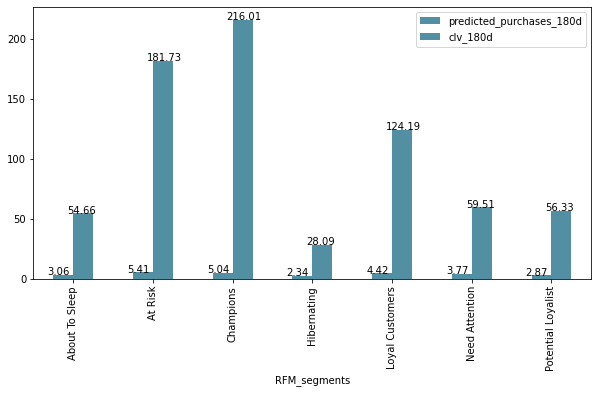

In [269]:
fig, ax = plt.subplots(figsize=(10,5))
clv_card_result.plot.bar(x = 'RFM_segments', y = ['predicted_purchases_180d', 'clv_180d'], ax = ax, color='#528fa3')
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2-0.2, p.get_height()))

### Home Rental

In [31]:
# divide customers into 5 groups by R, F, M
clv_rental['R_score'] = pd.qcut(clv_rental['recency'], 5, labels=[5, 4, 3, 2, 1])
clv_rental['F_score'] = pd.cut(clv_rental['frequency'].rank(pct=True), 
                             bins=5, labels=[1, 2, 3, 4, 5])
clv_rental['M_score'] = pd.qcut(clv_rental['monetary_value'], 5, labels=[1, 2, 3, 4, 5])
clv_rental['FM_score'] = (clv_rental['F_score'].astype(float)+clv_rental['M_score'].astype(float))/2

#segment
clv_rental['RFM_segments'] = clv_rental.apply(segment, axis=1)
clv_rental.head()

,frequency,recency,T,monetary_value,R_score,F_score,M_score,FM_score,RFM_segments
Customer_Id,,,,,,,,,
3238383834,2.0,81.0,419.0,2264.270020,4,1,5,3.0,Loyal Customers
3734343038,2.0,344.0,377.0,8634.315430,1,1,5,3.0,At Risk
313039333231,3.0,186.0,308.0,822.280029,3,4,4,4.0,Loyal Customers
313134303235,2.0,104.0,240.0,699.755005,3,1,4,2.5,Potential Loyalist
343135373330,2.0,22.0,31.0,641.709961,5,1,3,2.0,Potential Loyalist


In [32]:
clv_rental.RFM_segments.value_counts()

Potential Loyalist    130
Loyal Customers        70
At Risk                49
Need Attention         23
About To Sleep         20
Hibernating            13
Champions               2
Name: RFM_segments, dtype: int64

In [33]:
clv_rental['Total'] = clv_rental.groupby('RFM_segments').RFM_segments.transform('count')
clv_rental.sort_values('Total', ascending=False, inplace=True)
clv_rental.head()

,frequency,recency,T,monetary_value,R_score,F_score,M_score,FM_score,RFM_segments,Total
Customer_Id,,,,,,,,,,
3636353430363733,2.0,179.0,418.0,886.359985,3,1,4,2.5,Potential Loyalist,130
313135353731313231,2.0,120.0,227.0,512.640015,3,1,3,2.0,Potential Loyalist,130
323038363438333838,2.0,140.0,507.0,265.529999,3,1,1,1.0,Potential Loyalist,130
3739303136313837,2.0,145.0,381.0,275.399994,3,1,1,1.0,Potential Loyalist,130
313138303435303433,2.0,149.0,321.0,462.494995,3,1,3,2.0,Potential Loyalist,130


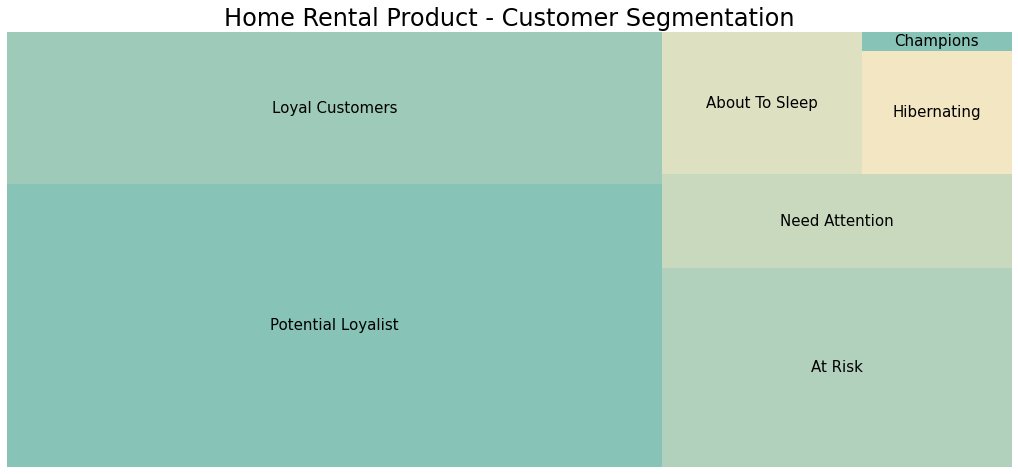

In [34]:
# visualize the top 7 on Merchant_Category
RFM_segments = clv_rental.RFM_segments.value_counts().reset_index()
RFM_segments.columns = ['labels', 'count']
names = RFM_segments['labels'].apply(str.title)
# plot
plt.figure(figsize=(18,8))
squarify.plot(sizes=RFM_segments['count'], label=names, 
                  color=sns.color_palette("blend:#5A9,#EDA"), 
                  alpha=.7, text_kwargs={'fontsize':15})
plt.axis('off')
plt.title("Home Rental Product - Customer Segmentation", fontsize=24)
plt.savefig('Home Rental Segmentation.png',transparent=True) 
plt.show()

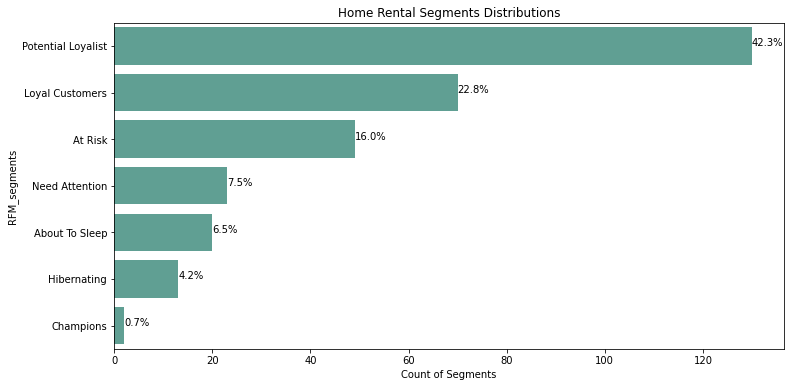

In [35]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(y="RFM_segments", data=clv_rental, color='#5A9')
plt.title('Home Rental Segments Distributions')
plt.xlabel('Count of Segments')

total = len(clv_rental)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

In [277]:
clv_rental = pd.merge(clv_rental, clv_result, on='Customer_Id',  how='left')
clv_rental.head()

,frequency,recency,T,monetary_value,R_score,F_score,M_score,FM_score,RFM_segments,Total,predicted_purchases_180d,clv_180d
Customer_Id,,,,,,,,,,,,
313039333231,3.0,186.0,308.0,822.280029,4,1,4,2.5,Potential Loyalist,30,8.250806,634.828125
323131363530303734,3.0,194.0,364.0,396.600006,3,1,2,1.5,Potential Loyalist,30,5.842087,229.180636
313132303432363931,3.0,159.0,346.0,497.063324,4,1,3,2.0,Potential Loyalist,30,7.707566,437.140661
313132393331313937,3.0,190.0,281.0,528.246704,4,1,3,2.0,Potential Loyalist,30,4.103052,252.512203
313533313331303732,3.0,190.0,387.0,479.963318,4,1,3,2.0,Potential Loyalist,30,8.903024,404.259131


In [278]:
clv_rental_result = clv_rental.groupby('RFM_segments', as_index=False)['predicted_purchases_180d','clv_180d'].agg(['mean']).reset_index()
clv_rental_result.columns = clv_rental_result.columns.droplevel(-1)
clv_rental_result

,RFM_segments,predicted_purchases_180d,clv_180d
0,About To Sleep,2.681589,136.830073
1,At Risk,5.742137,734.046169
2,Hibernating,6.127553,231.927565
3,Loyal Customers,4.572589,550.853818
4,Need Attention,4.226186,255.721462
5,Potential Loyalist,6.476222,397.138044


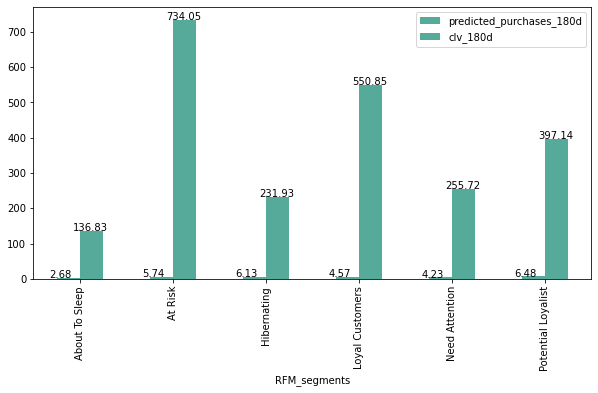

In [279]:
fig, ax = plt.subplots(figsize=(10,5))
clv_rental_result.plot.bar(x = 'RFM_segments', y = ['predicted_purchases_180d', 'clv_180d'], ax = ax, color='#5A9')
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2-0.2, p.get_height()))

## Merge RFM df

### Calculate each segment percentage of the total in hotel, card, home rental category

* Hotel Category

In [60]:
clv_hotel['RFM_segment_prob'] = round((clv_hotel.Total / len(clv_hotel))* 100,2)
# add service category
clv_hotel['service_category'] = 'Hotel'
clv_hotel.head()

,frequency,recency,T,monetary_value,R_score,F_score,M_score,FM_score,RFM_segments,Total,RFM_segment_prob,service_category
Customer_Id,,,,,,,,,,,,
3437363437393933,49.0,2375.0,2441.0,93.033875,3,4,5,4.5,Loyal Customers,326190,37.63,Hotel
3735383637393931,96.0,5278.0,5289.0,15.829792,2,5,2,3.5,Loyal Customers,326190,37.63,Hotel
3735383637393134,72.0,4181.0,4281.0,8.017083,2,5,1,3.0,Loyal Customers,326190,37.63,Hotel
3735383637383532,84.0,4165.0,4169.0,10.571786,2,5,1,3.0,Loyal Customers,326190,37.63,Hotel
313239383736313035,49.0,2735.0,2745.0,13.545714,3,4,2,3.0,Loyal Customers,326190,37.63,Hotel


* Card Category

In [51]:
clv_card['RFM_segment_prob'] = round((clv_card.Total / len(clv_card))* 100,2)
# add service category
clv_card['service_category'] = 'Card'
clv_card.head()

,frequency,recency,T,monetary_value,R_score,F_score,M_score,FM_score,RFM_segments,Total,RFM_segment_prob,service_category
Customer_Id,,,,,,,,,,,,
313339353639343337,29.0,1642.0,1706.0,18.819654,3,2,4,3.0,Loyal Customers,67377,40.21,Card
3937313639353935,56.0,1673.0,1724.0,27.701963,2,4,5,4.5,Loyal Customers,67377,40.21,Card
3937313730383837,42.0,1307.0,1342.0,23.525715,4,3,4,3.5,Loyal Customers,67377,40.21,Card
3937313730373037,52.0,1554.0,1600.0,19.489038,3,4,4,4.0,Loyal Customers,67377,40.21,Card
323133393432313530,56.0,1673.0,1714.0,8.764464,2,4,3,3.5,Loyal Customers,67377,40.21,Card


* Home Rental Category

In [52]:
clv_rental['RFM_segment_prob'] = round((clv_rental.Total / len(clv_rental))* 100,2)
# add service category
clv_rental['service_category'] = 'Home Rental'
clv_rental.head()

,frequency,recency,T,monetary_value,R_score,F_score,M_score,FM_score,RFM_segments,Total,RFM_segment_prob,service_category
Customer_Id,,,,,,,,,,,,
3636353430363733,2.0,179.0,418.0,886.359985,3,1,4,2.5,Potential Loyalist,130,42.35,Home Rental
313135353731313231,2.0,120.0,227.0,512.640015,3,1,3,2.0,Potential Loyalist,130,42.35,Home Rental
323038363438333838,2.0,140.0,507.0,265.529999,3,1,1,1.0,Potential Loyalist,130,42.35,Home Rental
3739303136313837,2.0,145.0,381.0,275.399994,3,1,1,1.0,Potential Loyalist,130,42.35,Home Rental
313138303435303433,2.0,149.0,321.0,462.494995,3,1,3,2.0,Potential Loyalist,130,42.35,Home Rental


* Merge three df

In [56]:
frames = [clv_hotel, clv_card, clv_rental]
rfm_combine = pd.concat(frames)
rfm_combine.RFM_segments.value_counts()

Loyal Customers       393637
Potential Loyalist    356851
At Risk               200280
Need Attention         43953
Champions              29405
About To Sleep          7640
Hibernating             2825
Name: RFM_segments, dtype: int64

In [57]:
rfm_combine = rfm_combine.reset_index()

In [58]:
# only remain RFM score, RFM segments, RFM_segment_prob
rfm_combine = rfm_combine[['Customer_Id','service_category','R_score','F_score','M_score','FM_score','RFM_segments','RFM_segment_prob']]
rfm_combine.rename(columns = {'Customer_Id':'customer_id'}, inplace = True)
rfm_combine.head()

,customer_id,service_category,R_score,F_score,M_score,FM_score,RFM_segments,RFM_segment_prob
0,3437363437393933,Hotel,3,4,5,4.5,Loyal Customers,37.63
1,3735383637393931,Hotel,2,5,2,3.5,Loyal Customers,37.63
2,3735383637393134,Hotel,2,5,1,3.0,Loyal Customers,37.63
3,3735383637383532,Hotel,2,5,1,3.0,Loyal Customers,37.63
4,313239383736313035,Hotel,3,4,2,3.0,Loyal Customers,37.63


In [59]:
rfm_combine.to_csv('rfm_combine.csv',index=False)